# 합성곱 신경망을 사용한 이미지 분류

~~합성곱 신경망에서 32개, 64개 필터로 볼륨을 늘리는 이유를 아직 모르겠네~~

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 패션 MNIST 데이터 불러오기

합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼칠 필요가 없다.   
하지만 깊이 차원이 있어야 하므로, 3차원 변환이 필요하다. -> reshape() 메서드 이용   

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

# 2차원을 3차원으로 변환    +   정규화
# 만약 컬러라면 (28, 28, 3)으로 바꾸어줘야 함
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


## 합성곱 신경망 만들기

In [3]:
model = keras.Sequential()

In [4]:
# 합성곱 층 Conv2D 추가
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))
# 32개 필터 사용, 커널 크기 (3,3), 렐루 활성화 함수 사용, same 패딩 사용, input_shape는 (28, 28, 1)로 변환했던 것을 사용

In [5]:
# 풀링층 추가 : MaxPooling2D 사용, 풀링 크기는 전형적인 (2,2) -> 사이즈가 1/2로 줄어든다.
model.add(keras.layers.MaxPooling2D(2))
# 최대 풀링을 통과한 특성맵의 크기는 (14, 14, 32)가 될 것이다.
# 각 층의 출력크기는 keras -> model.summary() 메서드로 확인할 수 있다.

In [6]:
# 두번째 합성곱-풀링 층 추가: 필터를 64로 늘렸다.
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))
# 최대 풀링을 통과해 특성맵의 크기가 (7, 7, 64)가 된다.

In [7]:
# 밀집층 추가 단계.
# 풀링층에서 전달받은 특성맵을 1차원으로 펼친다.
model.add(keras.layers.Flatten())
# 은닉층 추가
model.add(keras.layers.Dense(100, activation='relu'))
# Dropout: 은닉층의 과대 적합을 막아 성능을 개선 - 40% 드롭아웃
model.add(keras.layers.Dropout(0.4))
# 마지막 출력층: 10개를 분류하는 다중 분류 문제 - 활성화함수 'softmax'
model.add(keras.layers.Dense(10, activation='softmax'))

####### 합성곱 신경망의 구성 종료 #######

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

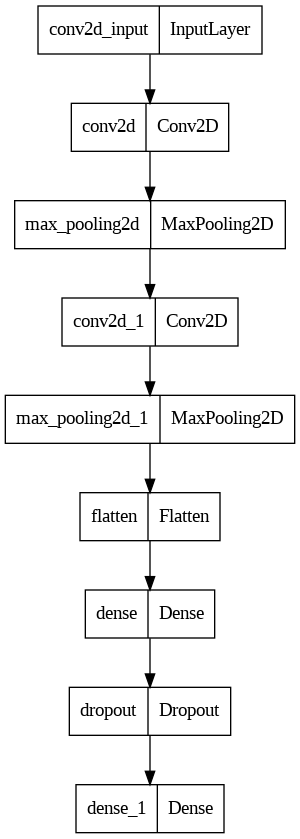

In [9]:
# 층의 구성을 그림으로 표현해주는 keras.utils.plot_model()
keras.utils.plot_model(model)

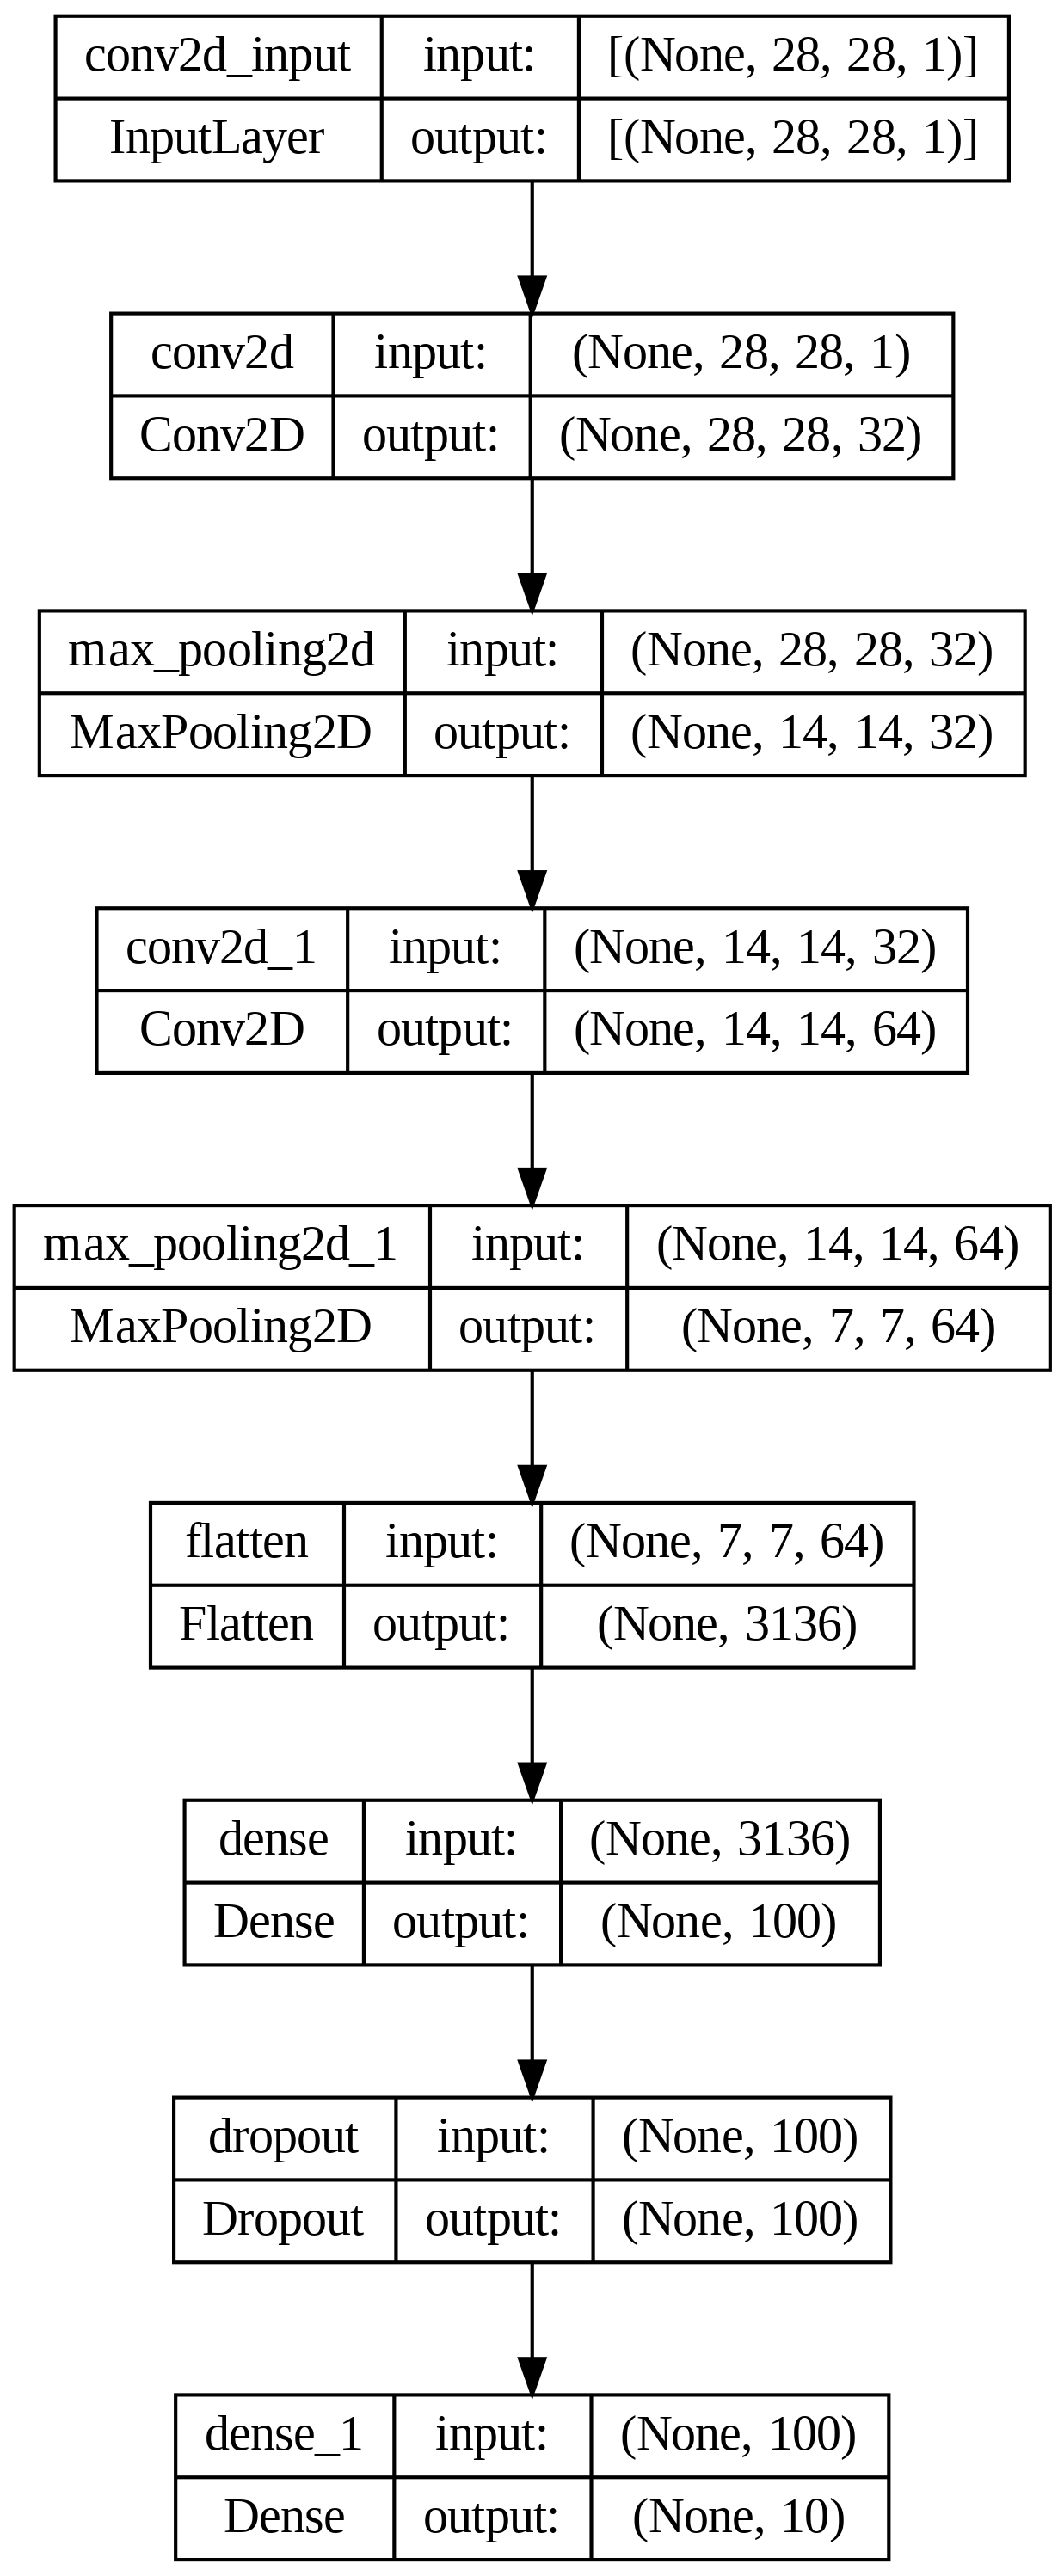

In [10]:
keras.utils.plot_model(model, show_shapes=True, to_file='cnn-architecture.png', dpi=300)
# show_shape=True로 하면, summary()에서 확인했던 것처럼 입력과 출력의 크기를 확인할 수 있다. 

In [ ]:
▼ 아래 그림 잘 기억해두자.

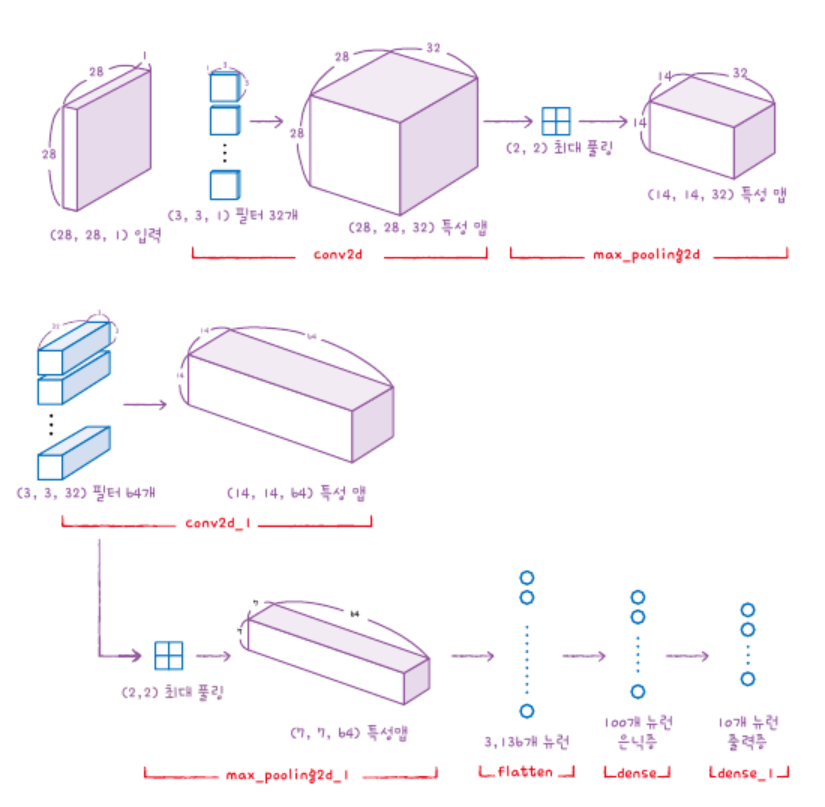

## 모델 컴파일과 훈련

In [12]:
# 모델 컴파일 (Adam 옵티마이저)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# 체크포인트: 최고 성능 모델 저장
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)

# 2번 연속 정확도가 증가하지 않을 경우 중단, 최적값으로 돌아가서 저장
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# 훈련 실시(에포크 30번, 검증 데이터 사용, 콜백 지정), history에 저장
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 21s 5ms/step - loss: 0.5062 - accuracy: 0.8188 - val_loss: 0.3097 - val_accuracy: 0.8852
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3351 - accuracy: 0.8797 - val_loss: 0.2796 - val_accuracy: 0.8953
Epoch 3/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2900 - accuracy: 0.8957 - val_loss: 0.2465 - val_accuracy: 0.9077
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2547 - accuracy: 0.9071 - val_loss: 0.2316 - val_accuracy: 0.9132
Epoch 5/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2328 - accuracy: 0.9133 - val_loss: 0.2251 - val_accuracy: 0.9181
Epoch 6/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2119 - accuracy: 0.9224 - val_loss: 0.2170 - val_accuracy: 0.9226
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1955 - accuracy: 0.9276 - val_loss: 0.2157 - val_accur

최종 정확도가 93%로, 이전보다 훨씬 좋아진 것을 확인할 수 있다.   
▼ 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인해보자.


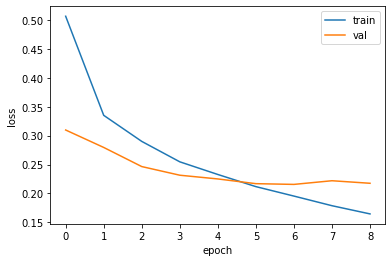

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [14]:
model.evaluate(val_scaled, val_target)
# 에포크 7의 val_accracy 값과 같다. 7번째(=9-2) 에포크(즉, index 6)이 최적 결과값인 것을 알 수 있다.

375/375 [==============================] - 1s 3ms/step - loss: 0.2157 - accuracy: 0.9221


[0.2157202810049057, 0.92208331823349]

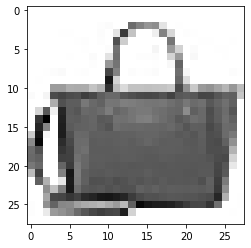

In [17]:
# 임의로 검증 세트의 첫번째 샘플로 확인해보자. 우선 이미지 확인.
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [18]:
# predict를 사용해서 예측해보자: 10개 클래스에 대한 예측 확률 - 가장 큰 확률값을 가지는 클래스로 예측
preds = model.predict(val_scaled[0:1])  # 샘플 입력시, (1, 28, 28, 1)의 크기를 전달해야 한다. 배열 슬라이싱으로 전체차원이 유지되도록 한다.
print(preds)

1/1 [==============================] - 0s 141ms/step
[[7.5558574e-16 2.7351212e-23 1.1266028e-20 1.9977543e-16 2.8580384e-17
  1.6671375e-12 4.9755573e-16 5.9750975e-17 1.0000000e+00 5.5114303e-17]]


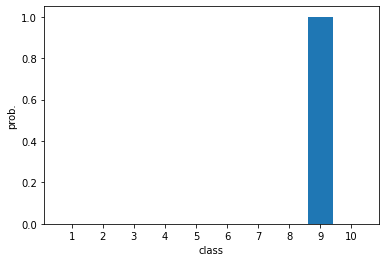

In [25]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.xticks(range(1,11), range(1,11))
# xticks 참고: https://jimmy-ai.tistory.com/17
plt.ylabel('prob.')
plt.show()

In [22]:
# 레이블 리스트 저장
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [ ]:
# np.argmax()로 최댓값의 '인덱스'를 classes에 적용하여 어떤 예측값을 가지는지 출력
import numpy as np
print(classes[np.argmax(preds)])

가방


마지막으로, 테스트 세트(test_scaled, test_target)로 합성곱 신경망의 일반화 성능 확인   
이미지 크기를 (28, 28) -> (28, 28, 1)로 변환 + 픽셀값의 범위를 0~1로 정규화

In [26]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

모델 평가 실시: evaluate()

In [28]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2363 - accuracy: 0.9168


[0.23628701269626617, 0.9168000221252441]

91%의 성능을 기대할 수 있다.